In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor, plot_importance
from statsmodels.tsa.stattools import grangercausalitytests
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Load the data
usd_regression_df = pd.read_csv('usd_regression_dataW8.csv')

In [ ]:
# Run OLS, Lasso (and then OLS) and random forest (and then OLS) for each (start, tenor) combination, on the same train/test split
macro_features = ['value_rate', '5y5y_inflation_swap','balance_sheet' ,'10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = usd_regression_df[['start_months', 'tenor_months']].drop_duplicates()
results_all = []

for _, row in combinations.iterrows():
    start = row['start_months']
    tenor = row['tenor_months']
    df_sub = usd_regression_df[(usd_regression_df['start_months'] == start) & (usd_regression_df['tenor_months'] == tenor)]
    df_sub = df_sub.dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- OLS on all features (baseline) using the train/test split ---
    ols_all = LinearRegression()
    ols_all.fit(X_train, y_train)
    y_train_pred = ols_all.predict(X_train)
    y_test_pred = ols_all.predict(X_test)
    coefs = ols_all.coef_

    # performance (train & test)
    n_train = len(y_train)
    n_test = len(y_test)
    p_all = X_train.shape[1]

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p_all - 1) if n_train > p_all + 1 else np.nan
    adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_all - 1) if n_test > p_all + 1 else np.nan

    # t-stats / p-values on train set (statsmodels)
    X_train_sm = sm.add_constant(X_train)
    sm_ols = sm.OLS(y_train, X_train_sm).fit()
    t_stats = sm_ols.tvalues[1:]  # exclude const
    p_values = sm_ols.pvalues[1:]

    # --- Lasso feature selection on same train set, then OLS refit on selected features ---
    lasso_pipe = make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42, n_jobs=-1, max_iter=10000))
    lasso_pipe.fit(X_train, y_train)
    lasso_coefs_raw = lasso_pipe.named_steps['lassocv'].coef_  # aligned with macro_features
    selected = [f for f, c in zip(macro_features, lasso_coefs_raw) if abs(c) > 1e-6]
    lasso_num = len(selected)

    # record lasso raw coefficients per feature
    lasso_coef_dict = {f'lasso_coef_{f}': float(c) for f, c in zip(macro_features, lasso_coefs_raw)}

    # metrics for lasso-refit OLS (use same train/test)
    if selected:
        ols_lasso = LinearRegression()
        ols_lasso.fit(X_train[selected], y_train)
        y_train_pred_lasso = ols_lasso.predict(X_train[selected])
        y_test_pred_lasso = ols_lasso.predict(X_test[selected])

        mse_train_lasso = mean_squared_error(y_train, y_train_pred_lasso)
        mse_test_lasso = mean_squared_error(y_test, y_test_pred_lasso)
        rmse_train_lasso = np.sqrt(mse_train_lasso)
        rmse_test_lasso = np.sqrt(mse_test_lasso)
        r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
        r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

        p_lasso = len(selected)
        adj_r2_train_lasso = 1 - (1 - r2_train_lasso) * (n_train - 1) / (n_train - p_lasso - 1) if n_train > p_lasso + 1 else np.nan
        adj_r2_test_lasso = 1 - (1 - r2_test_lasso) * (n_test - 1) / (n_test - p_lasso - 1) if n_test > p_lasso + 1 else np.nan
    else:
        mse_train_lasso = mse_test_lasso = rmse_train_lasso = rmse_test_lasso = np.nan
        r2_train_lasso = r2_test_lasso = adj_r2_train_lasso = adj_r2_test_lasso = np.nan

    # --- Random Forest feature importances on the same train/test split ---
    rf_model = RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_importances = rf_model.feature_importances_  # aligned with macro_features
    rf_imp_dict = {f'rf_imp_{f}': float(imp) for f, imp in zip(macro_features, rf_importances)}
    rf_selected = [f for f, imp in zip(macro_features, rf_importances) if imp >= 0.01]
    rf_num_selected = len(rf_selected)

    # Refit OLS using only RF-selected features (drop features with importance < 0.01)
    if rf_selected:
        ols_rfsel = LinearRegression()
        ols_rfsel.fit(X_train[rf_selected], y_train)
        y_test_pred_rfsel = ols_rfsel.predict(X_test[rf_selected])
        mse_test_rfsel = mean_squared_error(y_test, y_test_pred_rfsel)
        rmse_test_rfsel = np.sqrt(mse_test_rfsel)
        r2_test_rfsel = r2_score(y_test, y_test_pred_rfsel)

        p_rfsel = len(rf_selected)
        adj_r2_test_rfsel = 1 - (1 - r2_test_rfsel) * (n_test - 1) / (n_test - p_rfsel - 1) if n_test > p_rfsel + 1 else np.nan
    else:
        mse_test_rfsel = rmse_test_rfsel = r2_test_rfsel = adj_r2_test_rfsel = np.nan

    results_all.append({
        'start_months': start,
        'tenor_months': tenor,
        # OLS (all) coefficients
        **{f: float(c) for f, c in zip(macro_features, coefs)},
        # t-stats / p-values (train)
        **{f'tstat_{f}': float(t) for f, t in zip(macro_features, t_stats)},
        **{f'pval_{f}': float(p) for f, p in zip(macro_features, p_values)},
        # baseline performance (train & test)
        'MSE_train': float(mse_train),
        'MSE_test': float(mse_test),
        'RMSE_test': float(rmse_test),
        'R2_test': float(r2_test),
        'Adj_R2_test': float(adj_r2_test) if not np.isnan(adj_r2_test) else np.nan,
        # Lasso summary
        'lasso_num_selected': int(lasso_num),
        'lasso_selected_features': selected,
        **lasso_coef_dict,
        # Lasso -> OLS performance (train & test)
        'MSE_train_lasso': float(mse_train_lasso) if not np.isnan(mse_train_lasso) else np.nan,
        'MSE_test_lasso': float(mse_test_lasso) if not np.isnan(mse_test_lasso) else np.nan,
        'RMSE_test_lasso': float(rmse_test_lasso) if not np.isnan(rmse_test_lasso) else np.nan,
        'R2_test_lasso': float(r2_test_lasso) if not np.isnan(r2_test_lasso) else np.nan,
        'Adj_R2_test_lasso': float(adj_r2_test_lasso) if not np.isnan(adj_r2_test_lasso) else np.nan,
        'n_obs': len(df_sub),
        # Random Forest importances + RF-based OLS refit (same train/test)
        **rf_imp_dict,
        'rf_num_selected': int(rf_num_selected),
        'rf_selected_features': rf_selected,
        'MSE_test_rfsel': float(mse_test_rfsel) if not np.isnan(mse_test_rfsel) else np.nan,
        'RMSE_test_rfsel': float(rmse_test_rfsel) if not np.isnan(rmse_test_rfsel) else np.nan,
        'R2_test_rfsel': float(r2_test_rfsel) if not np.isnan(r2_test_rfsel) else np.nan,
        'Adj_R2_test_rfsel': float(adj_r2_test_rfsel) if not np.isnan(adj_r2_test_rfsel) else np.nan,
    })
    

df_all = pd.DataFrame(results_all)
df_all.to_csv('W10_usd_regression_results.csv', index=False)
df_all.head()

,start_months,tenor_months,value_rate,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope,tstat_value_rate,tstat_5y5y_inflation_swap,tstat_balance_sheet,...,rf_imp_5y5y_inflation_swap,rf_imp_balance_sheet,rf_imp_10y_swap_spread,rf_imp_3m3m_1y3m_curve_slope,rf_num_selected,rf_selected_features,MSE_test_rfsel,RMSE_test_rfsel,R2_test_rfsel,Adj_R2_test_rfsel
0,3,12,-0.266672,-0.930640,5.495582e-07,-0.037208,-0.329212,-11.180849,-6.943411,32.049748,...,0.035097,0.512596,0.044346,0.156251,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.765311,1.328650,0.407224,0.401355
1,3,24,0.049334,-0.956298,5.055598e-07,-0.027595,-0.471695,2.079440,-7.717772,32.642941,...,0.036604,0.646506,0.026774,0.072751,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.416620,1.190219,0.472555,0.467332
2,3,36,0.152017,-0.996353,4.728301e-07,-0.019508,-0.361423,5.816211,-7.953488,31.371496,...,0.038517,0.635835,0.023351,0.078225,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.303307,1.141625,0.469179,0.463924
3,3,60,0.162631,-0.891815,4.204705e-07,-0.002364,-0.100237,5.806960,-7.565901,32.138983,...,0.046401,0.611910,0.031102,0.059983,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.931924,0.965362,0.445998,0.440513
4,3,84,0.204145,-1.303793,4.346334e-07,0.001063,0.086497,6.908659,-11.360092,36.476007,...,0.078306,0.628853,0.062274,0.042891,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.750023,0.866039,0.470002,0.464755
5,3,120,0.181972,-1.829783,4.587655e-07,0.005224,0.295942,6.005904,-16.594255,42.681171,...,0.107275,0.621556,0.084529,0.027014,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.576143,0.759041,0.519925,0.515172
6,3,360,0.127219,-2.660441,5.013724e-07,0.007990,0.538434,3.401804,-22.432486,45.730423,...,0.045922,0.572093,0.073712,0.045213,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.441689,0.664597,0.636229,0.632627
7,6,12,-0.140268,-0.604057,5.277881e-07,-0.029996,-0.540105,-6.706726,-5.188975,35.582207,...,0.025455,0.672334,0.017324,0.087356,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.302516,1.141278,0.482958,0.477839
8,6,24,0.081673,-0.545224,4.704644e-07,-0.022657,-0.552420,3.640203,-4.829660,33.925492,...,0.019491,0.654525,0.021645,0.082088,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",1.038745,1.019188,0.495845,0.490853
9,6,36,0.144088,-0.504330,4.264672e-07,-0.015274,-0.400043,5.812316,-4.414589,31.720699,...,0.021791,0.640001,0.015348,0.086320,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.965586,0.982642,0.473873,0.468664


In [ ]:
# Compute and compare mean test R2 for OLS, Lasso->OLS and RF->OLS (already present)
rf_col = 'R2_test_rfsel' if 'R2_test_rfsel' in df_all.columns else ('R2_test_rf' if 'R2_test_rf' in df_all.columns else None)

mean_ols = df_all['R2_test'].mean() if 'R2_test' in df_all.columns else np.nan
mean_lasso = df_all['R2_test_lasso'].mean() if 'R2_test_lasso' in df_all.columns else np.nan
mean_rf = df_all[rf_col].mean() if rf_col is not None else np.nan

print(f"Mean R2_test (OLS)        : {mean_ols:.4f}")
print(f"Mean R2_test (Lasso->OLS) : {mean_lasso:.4f}")
print(f"Mean R2_test (RF->OLS)    : {mean_rf:.4f}")

pd.DataFrame({
    'model': ['OLS', 'Lasso->OLS', 'RF->OLS'],
    'mean_R2_test': [mean_ols, mean_lasso, mean_rf]
})


Mean R2_test (OLS)        : 0.4824
Mean R2_test (Lasso->OLS) : 0.4823
Mean R2_test (RF->OLS)    : 0.4824


,model,mean_R2_test
0,OLS,0.482432
1,Lasso->OLS,0.482304
2,RF->OLS,0.482432


In [5]:
adj_rf_col = 'Adj_R2_test_rfsel' if 'Adj_R2_test_rfsel' in df_all.columns else ('Adj_R2_test_rf' if 'Adj_R2_test_rf' in df_all.columns else None)

mean_adj_ols = df_all['Adj_R2_test'].mean() if 'Adj_R2_test' in df_all.columns else np.nan
mean_adj_lasso = df_all['Adj_R2_test_lasso'].mean() if 'Adj_R2_test_lasso' in df_all.columns else np.nan
mean_adj_rf = df_all[adj_rf_col].mean() if adj_rf_col is not None else np.nan

print(f"Mean Adj_R2_test (OLS)        : {mean_adj_ols:.4f}")
print(f"Mean Adj_R2_test (Lasso->OLS) : {mean_adj_lasso:.4f}")
print(f"Mean Adj_R2_test (RF->OLS)    : {mean_adj_rf:.4f}")

pd.DataFrame({
    'model': ['OLS', 'Lasso->OLS', 'RF->OLS'],
    'mean_Adj_R2_test': [mean_adj_ols, mean_adj_lasso, mean_adj_rf]
})

Mean Adj_R2_test (OLS)        : 0.4773
Mean Adj_R2_test (Lasso->OLS) : 0.4774
Mean Adj_R2_test (RF->OLS)    : 0.4773


,model,mean_Adj_R2_test
0,OLS,0.477307
1,Lasso->OLS,0.477409
2,RF->OLS,0.477307


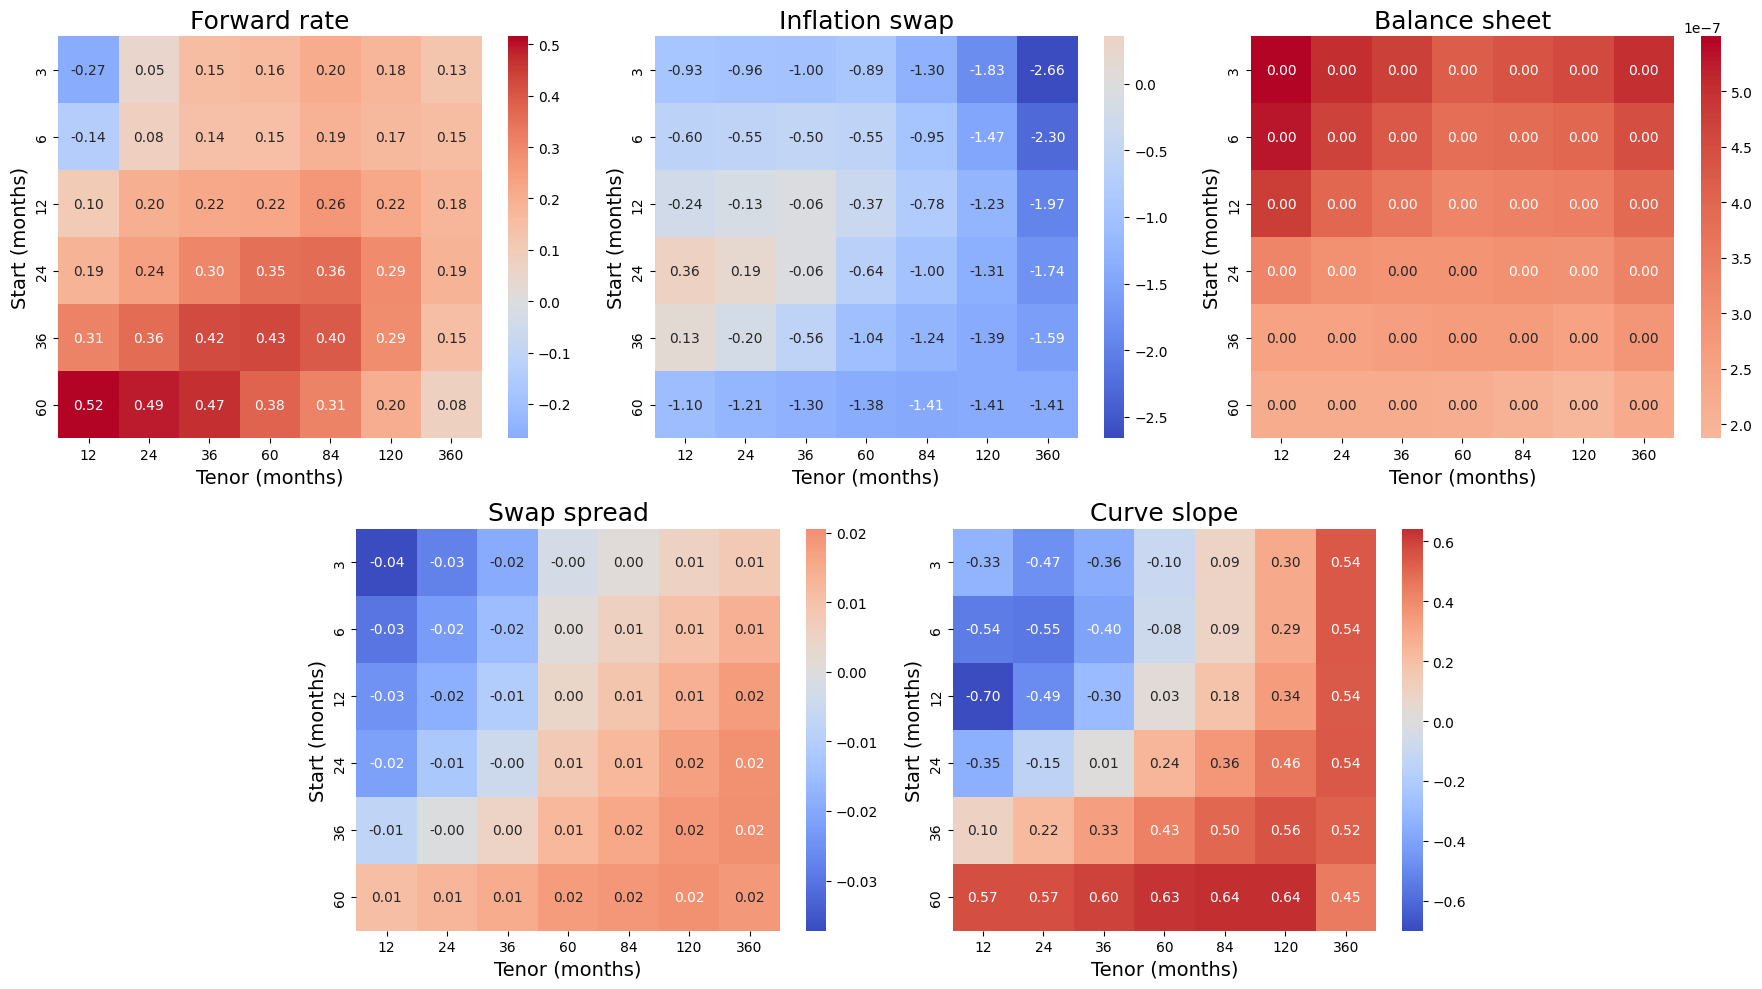

In [ ]:
# OLS heatmaps for coefficients
label_map = {
    'value_rate': 'Forward rate',
    '5y5y_inflation_swap': 'Inflation swap',
    'balance_sheet': 'Balance sheet',
    '10y_swap_spread': 'Swap spread',
    '3m3m_1y3m_curve_slope': 'Curve slope'
}

# Create pivot tables for each macro feature
pivot_tables = []
for feature in macro_features:
    pivot = df_all.pivot(index='start_months', columns='tenor_months', values=feature)
    pivot_tables.append(pivot)

fig = plt.figure(figsize=(18, 10))
# Create a 2-row × 6-column grid to allow horizontal shifting
gs = fig.add_gridspec(2, 6)

# First row (keep as is)
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Second row (shifted to be between top plots)
ax4 = fig.add_subplot(gs[1, 1:3])  # between ax1 and ax2
ax5 = fig.add_subplot(gs[1, 3:5])  # between ax2 and ax3

axes = [ax1, ax2, ax3, ax4, ax5]

# Plot heatmaps
for ax, (feature, pivot) in zip(axes, zip(macro_features, pivot_tables)):
    sns.heatmap(
        pivot, ax=ax, cmap='coolwarm', center=0, annot=True, fmt=".2f",
        cbar=True, vmin=np.nanmin(pivot.values), vmax=np.nanmax(pivot.values)
    )
    ax.set_title(label_map[feature], fontsize=18)  # use pretty names
    ax.set_xlabel('Tenor (months)', fontsize=14)
    ax.set_ylabel('Start (months)', fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
# Filter data for 2021-2024 before running the regression

df_2020_2024 = usd_regression_df[(usd_regression_df['date'] >= '2021-06-01') & (usd_regression_df['date'] <= '2025-11-01')]

macro_features = ['value_rate', '5y5y_inflation_swap','balance_sheet' ,'10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = df_2020_2024[['start_months', 'tenor_months']].drop_duplicates()
results_all = []

for _, row in combinations.iterrows():
    start = row['start_months']
    tenor = row['tenor_months']
    df_sub = df_2020_2024[(df_2020_2024['start_months'] == start) & (df_2020_2024['tenor_months'] == tenor)]
    df_sub = df_sub.dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue
    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    ols_all = LinearRegression()
    ols_all.fit(X_train, y_train)
    y_train_pred = ols_all.predict(X_train)
    y_test_pred = ols_all.predict(X_test)
    coefs = ols_all.coef_
# Calculate adjusted R2 for train and test
    n_train = len(y_train)
    n_test = len(y_test)
    p = X_train.shape[1]
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1) if n_train > p + 1 else np.nan
    adj_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p - 1) if n_test > p + 1 else np.nan

    # RMSE for train and test
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    results_all.append({
        'start_months': start,
        'tenor_months': tenor,
        **{f: c for f, c in zip(macro_features, coefs)},
        'MSE_train': mean_squared_error(y_train, y_train_pred),
        'MSE_test': mean_squared_error(y_test, y_test_pred),
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test,
        'R2_train': r2_train,
        'R2_test': r2_test,
        'Adj_R2_train': adj_r2_train,
        'Adj_R2_test': adj_r2_test,
        'n_obs': len(df_sub)
    })

df_all_22 = pd.DataFrame(results_all)
df_all_22.head()

,start_months,tenor_months,value_rate,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope,MSE_train,MSE_test,RMSE_train,RMSE_test,R2_train,R2_test,Adj_R2_train,Adj_R2_test,n_obs
0,3,12,-0.275704,0.785007,3.486762e-06,-0.044716,-1.317113,2.159170,1.739806,1.469412,1.319017,0.545266,0.488814,0.541373,0.470814,738
1,3,24,0.170959,0.453475,2.919139e-06,-0.054175,-1.274708,1.158605,0.933285,1.076385,0.966067,0.615107,0.595060,0.611812,0.580802,738
2,3,36,0.366214,0.009767,3.102042e-06,-0.024739,-1.138689,0.849292,0.692169,0.921570,0.831967,0.685939,0.695415,0.683251,0.684690,738
3,3,60,0.442135,-0.456334,2.698536e-06,0.015182,-0.682390,0.392003,0.316377,0.626101,0.562474,0.734805,0.768802,0.732534,0.760661,738
4,3,84,0.481156,-0.906597,2.708092e-06,0.038119,-0.441541,0.276876,0.212141,0.526190,0.460588,0.761701,0.807690,0.759660,0.800919,738
5,3,120,0.491632,-1.458546,2.652152e-06,0.069779,-0.061131,0.200769,0.149757,0.448072,0.386985,0.769836,0.829271,0.767866,0.823259,738
6,3,360,0.452209,-1.455407,2.129712e-06,0.080883,0.420352,0.188150,0.168167,0.433762,0.410082,0.700915,0.741068,0.698354,0.731951,738
7,6,12,-0.085733,1.084334,2.564458e-06,-0.050637,-1.185306,1.438583,1.198544,1.199410,1.094780,0.487622,0.397290,0.483235,0.376068,738
8,6,24,0.314909,0.187178,2.607948e-06,-0.024159,-1.027235,0.696265,0.797336,0.834425,0.892937,0.666026,0.647070,0.663162,0.634643,737
9,6,36,0.454638,-0.143587,2.736176e-06,-0.002104,-0.905348,0.487835,0.542343,0.698452,0.736439,0.736596,0.731386,0.734337,0.721928,737


In [ ]:
def print_mean_r2(df, name):
    if df is None or 'R2_test' not in df.columns:
        print(f"{name}: R2_test not available")
        return
    mean_r2 = np.nanmean(df['R2_test'])
    n = df['R2_test'].notna().sum()
    print(f"{name} — mean R2_test: {mean_r2:.4f}  (n={n})")

print_mean_r2(df_all if 'df_all' in globals() else None, 'df_all')
print_mean_r2(df_all_22 if 'df_all_22' in globals() else None, 'df_all_22')

# Optional: mean of adjusted R2
def print_mean_adj_r2(df, name):
    if df is None or 'Adj_R2_test' not in df.columns:
        print(f"{name}: Adj_R2_test not available")
        return
    mean_adj = np.nanmean(df['Adj_R2_test'])
    n = df['Adj_R2_test'].notna().sum()
    print(f"{name} — mean Adj_R2_test: {mean_adj:.4f}  (n={n})")

print_mean_adj_r2(df_all if 'df_all' in globals() else None, 'df_all')
print_mean_adj_r2(df_all_22 if 'df_all_22' in globals() else None, 'df_all_22')

df_all — mean R2_test: 0.4824  (n=42)
df_all_22 — mean R2_test: 0.7685  (n=42)
df_all — mean Adj_R2_test: 0.4773  (n=42)
df_all_22 — mean Adj_R2_test: 0.7603  (n=42)


# Leave one feature out

In [ ]:
# ...existing code...
# Refit OLS using only features that *decrease* MSE (i.e. removing them increases test MSE -> LOFO > 0)
macro_features = ['value_rate', '5y5y_inflation_swap', 'balance_sheet', '10y_swap_spread', '3m3m_1y3m_curve_slope']
combinations = usd_regression_df[['start_months', 'tenor_months']].drop_duplicates().values.tolist()

results_refit = []
for start, tenor in combinations:
    df_sub = usd_regression_df.query("start_months == @start and tenor_months == @tenor").dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # baseline test error with all features
    base_model = LinearRegression().fit(X_train, y_train)
    y_pred_base = base_model.predict(X_test)
    mse_base = mean_squared_error(y_test, y_pred_base)

    # LOFO: compute ΔMSE = MSE_without_feature - MSE_with_all
    lofo_scores = {}
    for f in macro_features:
        X_train_lofo = X_train.drop(columns=[f])
        X_test_lofo = X_test.drop(columns=[f])
        m_lofo = LinearRegression().fit(X_train_lofo, y_train)
        y_pred_lofo = m_lofo.predict(X_test_lofo)
        e_lofo = mean_squared_error(y_test, y_pred_lofo)
        lofo_scores[f] = e_lofo - mse_base

    # select features that decrease MSE when present (lofo > 0)
    selected = [f for f, delta in lofo_scores.items() if delta > 0]
    n_selected = len(selected)

    if n_selected == 0:
        # record that no feature reduced MSE
        results_refit.append({
            'start_months': start,
            'tenor_months': tenor,
            'selected_features': [],
            'n_selected': 0,
            'R2_test_refit': np.nan,
            'Adj_R2_test_refit': np.nan,
            'MSE_test_refit': np.nan,
            'RMSE_test_refit': np.nan,
            **{f'lofo_{f}': float(lofo_scores[f]) for f in macro_features}
        })
        continue

    # Refit OLS on selected features and compute out-of-sample metrics
    ols_sel = LinearRegression().fit(X_train[selected], y_train)
    y_test_pred_sel = ols_sel.predict(X_test[selected])

    mse_test_sel = mean_squared_error(y_test, y_test_pred_sel)
    rmse_test_sel = np.sqrt(mse_test_sel)
    r2_test_sel = r2_score(y_test, y_test_pred_sel)

    n_test = len(y_test)
    p = len(selected)
    adj_r2_test_sel = 1 - (1 - r2_test_sel) * (n_test - 1) / (n_test - p - 1) if n_test > p + 1 else np.nan

    results_refit.append({
        'start_months': start,
        'tenor_months': tenor,
        'selected_features': selected,
        'n_selected': n_selected,
        'R2_test_refit': float(r2_test_sel),
        'Adj_R2_test_refit': float(adj_r2_test_sel) if not np.isnan(adj_r2_test_sel) else np.nan,
        'MSE_test_refit': float(mse_test_sel),
        'RMSE_test_refit': float(rmse_test_sel),
        **{f'lofo_{f}': float(lofo_scores[f]) for f in macro_features}
    })

df_refit = pd.DataFrame(results_refit)
df_refit.to_csv('W9_usd_ols_refit_lofo.csv', index=False)

# Quick summary
print(f"Refit combos: {len(df_refit)}")
if 'R2_test_refit' in df_refit.columns and df_refit['R2_test_refit'].notna().any():
    print(f"Mean R2_test (refit): {df_refit['R2_test_refit'].mean():.4f}  (n={df_refit['R2_test_refit'].notna().sum()})")
    display(df_refit.sort_values('R2_test_refit', ascending=False).head(10))
else:
    print("No successful refits (no features selected for any combination).")
# ...existing code...

Refit combos: 42
Mean R2_test (refit): 0.4827  (n=42)


,start_months,tenor_months,selected_features,n_selected,R2_test_refit,Adj_R2_test_refit,MSE_test_refit,RMSE_test_refit,lofo_value_rate,lofo_5y5y_inflation_swap,lofo_balance_sheet,lofo_10y_swap_spread,lofo_3m3m_1y3m_curve_slope
41,60,360,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.727609,0.724912,0.071328,0.267073,0.000354,0.023829,0.066523,0.007330,0.026663
34,36,360,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.702340,0.699392,0.102496,0.320150,0.002301,0.032596,0.120984,0.008986,0.034906
27,24,360,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.687222,0.684126,0.138378,0.371992,0.004044,0.041596,0.180927,0.008363,0.037010
20,12,360,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.668172,0.664887,0.212650,0.461139,0.005050,0.059710,0.286413,0.006186,0.033970
13,6,360,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.660887,0.657530,0.304818,0.552103,0.004410,0.087247,0.402468,0.003805,0.035816
6,3,360,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.636229,0.632627,0.441689,0.664597,0.003587,0.118834,0.520112,0.001074,0.038248
14,12,12,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.578705,0.574534,1.047515,1.023482,0.014392,0.002253,0.860451,0.019747,0.054849
15,12,24,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.541103,0.536560,0.906817,0.952269,0.032104,0.000815,0.594841,0.010454,0.028363
5,3,120,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.519925,0.515172,0.576143,0.759041,0.010440,0.075351,0.611800,0.000346,0.010390
12,6,120,"[value_rate, 5y5y_inflation_swap, balance_shee...",5,0.516760,0.511975,0.432118,0.657357,0.007493,0.046388,0.447821,0.001983,0.008762


# Metrics

In [ ]:
# Compare full time window ws ith 2021-2024 filtered results

mean_r2_refit = df_refit['R2_test_refit'].mean() # 0.4827
mean_adj_r2_refit = df_refit['Adj_R2_test_refit'].mean() # 0.4778
mean_mse_refit = df_refit['MSE_test_refit'].mean() # 0.5666

mean_r2_base = df_all['R2_test'].mean(), #0.4824
mean_adj_r2_base = df_all['Adj_R2_test'].mean() # 0.4773
mean_mse_base = df_all['MSE_test'].mean() # 0.5671


In [ ]:
mean_mse_base

0.5671190307556988

In [ ]:
mean_r2_rf = df_all['R2_test_rfsel'].mean(), #0.4818
mean_adj_r2_rf= df_all['Adj_R2_test_rfsel'].mean() # 0.47678
mean_mse_rf = df_all['MSE_test_rfsel'].mean() # 0.56851

In [ ]:
mean_mse_rf

0.5671190307556988

In [ ]:
# Show mean R2_test for OLS, Lasso->OLS and RF->OLS (robust to column name variations)
def find_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

model_cols = {
    'OLS': ['R2_test'],
    'Lasso->OLS': ['R2_test_lasso', 'R2_test_lasso'],  # keep candidates for safety
    'RF->OLS': ['R2_test_rfsel', 'R2_test_rf', 'R2_test_rfsel']
}

def mean_r2_summary(df, df_name):
    rows = []
    for model, candidates in model_cols.items():
        col = find_column(df, candidates)
        if col is None:
            rows.append({'model': model, 'col_used': None, 'mean_R2_test': np.nan, 'n_nonmissing': 0})
            continue
        mean_val = float(df[col].mean())
        n = int(df[col].notna().sum())
        rows.append({'model': model, 'col_used': col, 'mean_R2_test': mean_val, 'n_nonmissing': n})
    out = pd.DataFrame(rows)
    print(f"{df_name} — mean R2_test by model")
    print(out[['model','col_used','mean_R2_test','n_nonmissing']])
    return out

# apply to df_all and df_refit (if present)
summ_all = mean_r2_summary(df_all, 'df_all') if 'df_all' in globals() else None
summ_refit = mean_r2_summary(df_refit, 'df_refit') if 'df_refit' in globals() else None

# combined table (optional)
combined = pd.concat([summ_all.assign(dataset='df_all') if summ_all is not None else pd.DataFrame(),
                      summ_refit.assign(dataset='df_refit') if summ_refit is not None else pd.DataFrame()],
                     ignore_index=True)
combined
# ...existing code...

df_all — mean R2_test by model
        model       col_used  mean_R2_test  n_nonmissing
0         OLS        R2_test      0.482432            42
1  Lasso->OLS  R2_test_lasso      0.482304            42
2     RF->OLS  R2_test_rfsel      0.482432            42
df_refit — mean R2_test by model
        model col_used  mean_R2_test  n_nonmissing
0         OLS     None           NaN             0
1  Lasso->OLS     None           NaN             0
2     RF->OLS     None           NaN             0


,model,col_used,mean_R2_test,n_nonmissing,dataset
0,OLS,R2_test,0.482432,42,df_all
1,Lasso->OLS,R2_test_lasso,0.482304,42,df_all
2,RF->OLS,R2_test_rfsel,0.482432,42,df_all
3,OLS,None,NaN,0,df_refit
4,Lasso->OLS,None,NaN,0,df_refit
5,RF->OLS,None,NaN,0,df_refit


# Lasso

In [ ]:
df_lasso = pd.read_csv("W10_usd_regression_results.csv")

# Step 1: Identify dropped features per combo
def get_dropped(selected_features, all_features):
    selected = eval(selected_features) if isinstance(selected_features, str) else selected_features
    return [f for f in all_features if f not in selected]

macro_features = ['value_rate', '5y5y_inflation_swap','balance_sheet','10y_swap_spread','3m3m_1y3m_curve_slope']
df_lasso["dropped"] = df_lasso["lasso_selected_features"].apply(lambda s: get_dropped(s, macro_features))

# Step 2: Keep only rows where at least one feature dropped
df_dropped = df_lasso[df_lasso["dropped"].apply(lambda x: len(x) > 0)].copy()

# Step 3: Build summary table
summary = df_dropped[["start_months","tenor_months","dropped","R2_test","Adj_R2_test","MSE_test"]]

# Step 4: Compute mean metrics
means = summary[["R2_test","Adj_R2_test","MSE_test"]].mean().to_frame("Mean").T

print("Summary of combinations where LASSO dropped at least one feature:")
display(summary.head(20))   # first 20 rows
print("\nMean metrics across dropped-feature models:")
print(means)#

# Step 5: Compare with baseline
baseline_means = df_all[["R2_test","Adj_R2_test","MSE_test"]].mean().to_frame("Baseline Mean").T

comparison = pd.concat([means, baseline_means])
print("\nComparison LASSO vs Baseline OLS:")
print(comparison)

Summary of combinations where LASSO dropped at least one feature:


,start_months,tenor_months,dropped,R2_test,Adj_R2_test,MSE_test
3,3,60,[10y_swap_spread],0.445998,0.440513,0.931924
4,3,84,[10y_swap_spread],0.470002,0.464755,0.750023
15,12,24,[5y5y_inflation_swap],0.541103,0.536560,0.906817
16,12,36,[5y5y_inflation_swap],0.504898,0.499996,0.820467
17,12,60,[3m3m_1y3m_curve_slope],0.450672,0.445234,0.572903
23,24,36,"[5y5y_inflation_swap, 3m3m_1y3m_curve_slope]",0.459949,0.454602,0.572148
29,36,24,"[5y5y_inflation_swap, 10y_swap_spread]",0.402997,0.397086,0.488493



Mean metrics across dropped-feature models:
       R2_test  Adj_R2_test  MSE_test
Mean  0.467946     0.462678  0.720396

Comparison LASSO vs Baseline OLS:
                R2_test  Adj_R2_test  MSE_test
Mean           0.467946     0.462678  0.720396
Baseline Mean  0.482432     0.477307  0.567119


# Random forest

# Compare only the R2 of OLS combinations where Lasso removed one parameter

In [ ]:
# filter all the df_all where the column 'lasso_num_selected' is less than 5
df_lasso_removed = df_all[df_all['lasso_num_selected'] < 5]
df_lasso_removed


,start_months,tenor_months,value_rate,5y5y_inflation_swap,balance_sheet,10y_swap_spread,3m3m_1y3m_curve_slope,tstat_value_rate,tstat_5y5y_inflation_swap,tstat_balance_sheet,...,rf_imp_5y5y_inflation_swap,rf_imp_balance_sheet,rf_imp_10y_swap_spread,rf_imp_3m3m_1y3m_curve_slope,rf_num_selected,rf_selected_features,MSE_test_rfsel,RMSE_test_rfsel,R2_test_rfsel,Adj_R2_test_rfsel
3,3,60,0.162631,-0.891815,4.204705e-07,-0.002364,-0.100237,5.806960,-7.565901,32.138983,...,0.046401,0.611910,0.031102,0.059983,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.931924,0.965362,0.445998,0.440513
4,3,84,0.204145,-1.303793,4.346334e-07,0.001063,0.086497,6.908659,-11.360092,36.476007,...,0.078306,0.628853,0.062274,0.042891,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.750023,0.866039,0.470002,0.464755
15,12,24,0.197932,-0.131808,3.966571e-07,-0.018609,-0.485533,8.469503,-1.218194,30.899145,...,0.032432,0.533719,0.050862,0.053534,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.906817,0.952269,0.541103,0.536560
16,12,36,0.217623,-0.058183,3.629028e-07,-0.010792,-0.296859,8.483159,-0.529078,29.202154,...,0.049038,0.554942,0.054738,0.053127,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.820467,0.905797,0.504898,0.499996
17,12,60,0.223817,-0.371046,3.277676e-07,0.003969,0.025486,8.489007,-3.626866,30.815925,...,0.087380,0.595139,0.029037,0.051973,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.572903,0.756903,0.450672,0.445234
23,24,36,0.303217,-0.057505,2.902913e-07,-0.004358,0.010272,10.843410,-0.543045,26.997126,...,0.258386,0.495889,0.038347,0.053112,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.572148,0.756405,0.459949,0.454602
29,36,24,0.360756,-0.197848,2.529755e-07,-0.000427,0.219794,12.465191,-1.888615,25.119364,...,0.356053,0.416388,0.025623,0.083863,5,"[value_rate, 5y5y_inflation_swap, balance_shee...",0.488493,0.698922,0.402997,0.397086


In [ ]:
mean_r2_lasso = df_lasso_removed['R2_test_lasso'].mean() # 0.467175
mean_adj_r2_lasso = df_lasso_removed['Adj_R2_test_lasso'].mean() # 0.463288
mean_mse_lasso = df_lasso_removed['MSE_test_lasso'].mean() # 0.721145

mean_r2_base = df_lasso_removed['R2_test'].mean(), #0.4679456
mean_adj_r2_base = df_lasso_removed['Adj_R2_test'].mean() # 0.462677
mean_mse_base = df_lasso_removed['MSE_test'].mean() # 0.720396

In [ ]:
mean_mse_base

0.7203964558672858

In [ ]:
mean_adj_r2_base

0.46267776992976933

# Leave One Feature Out - shorter figure

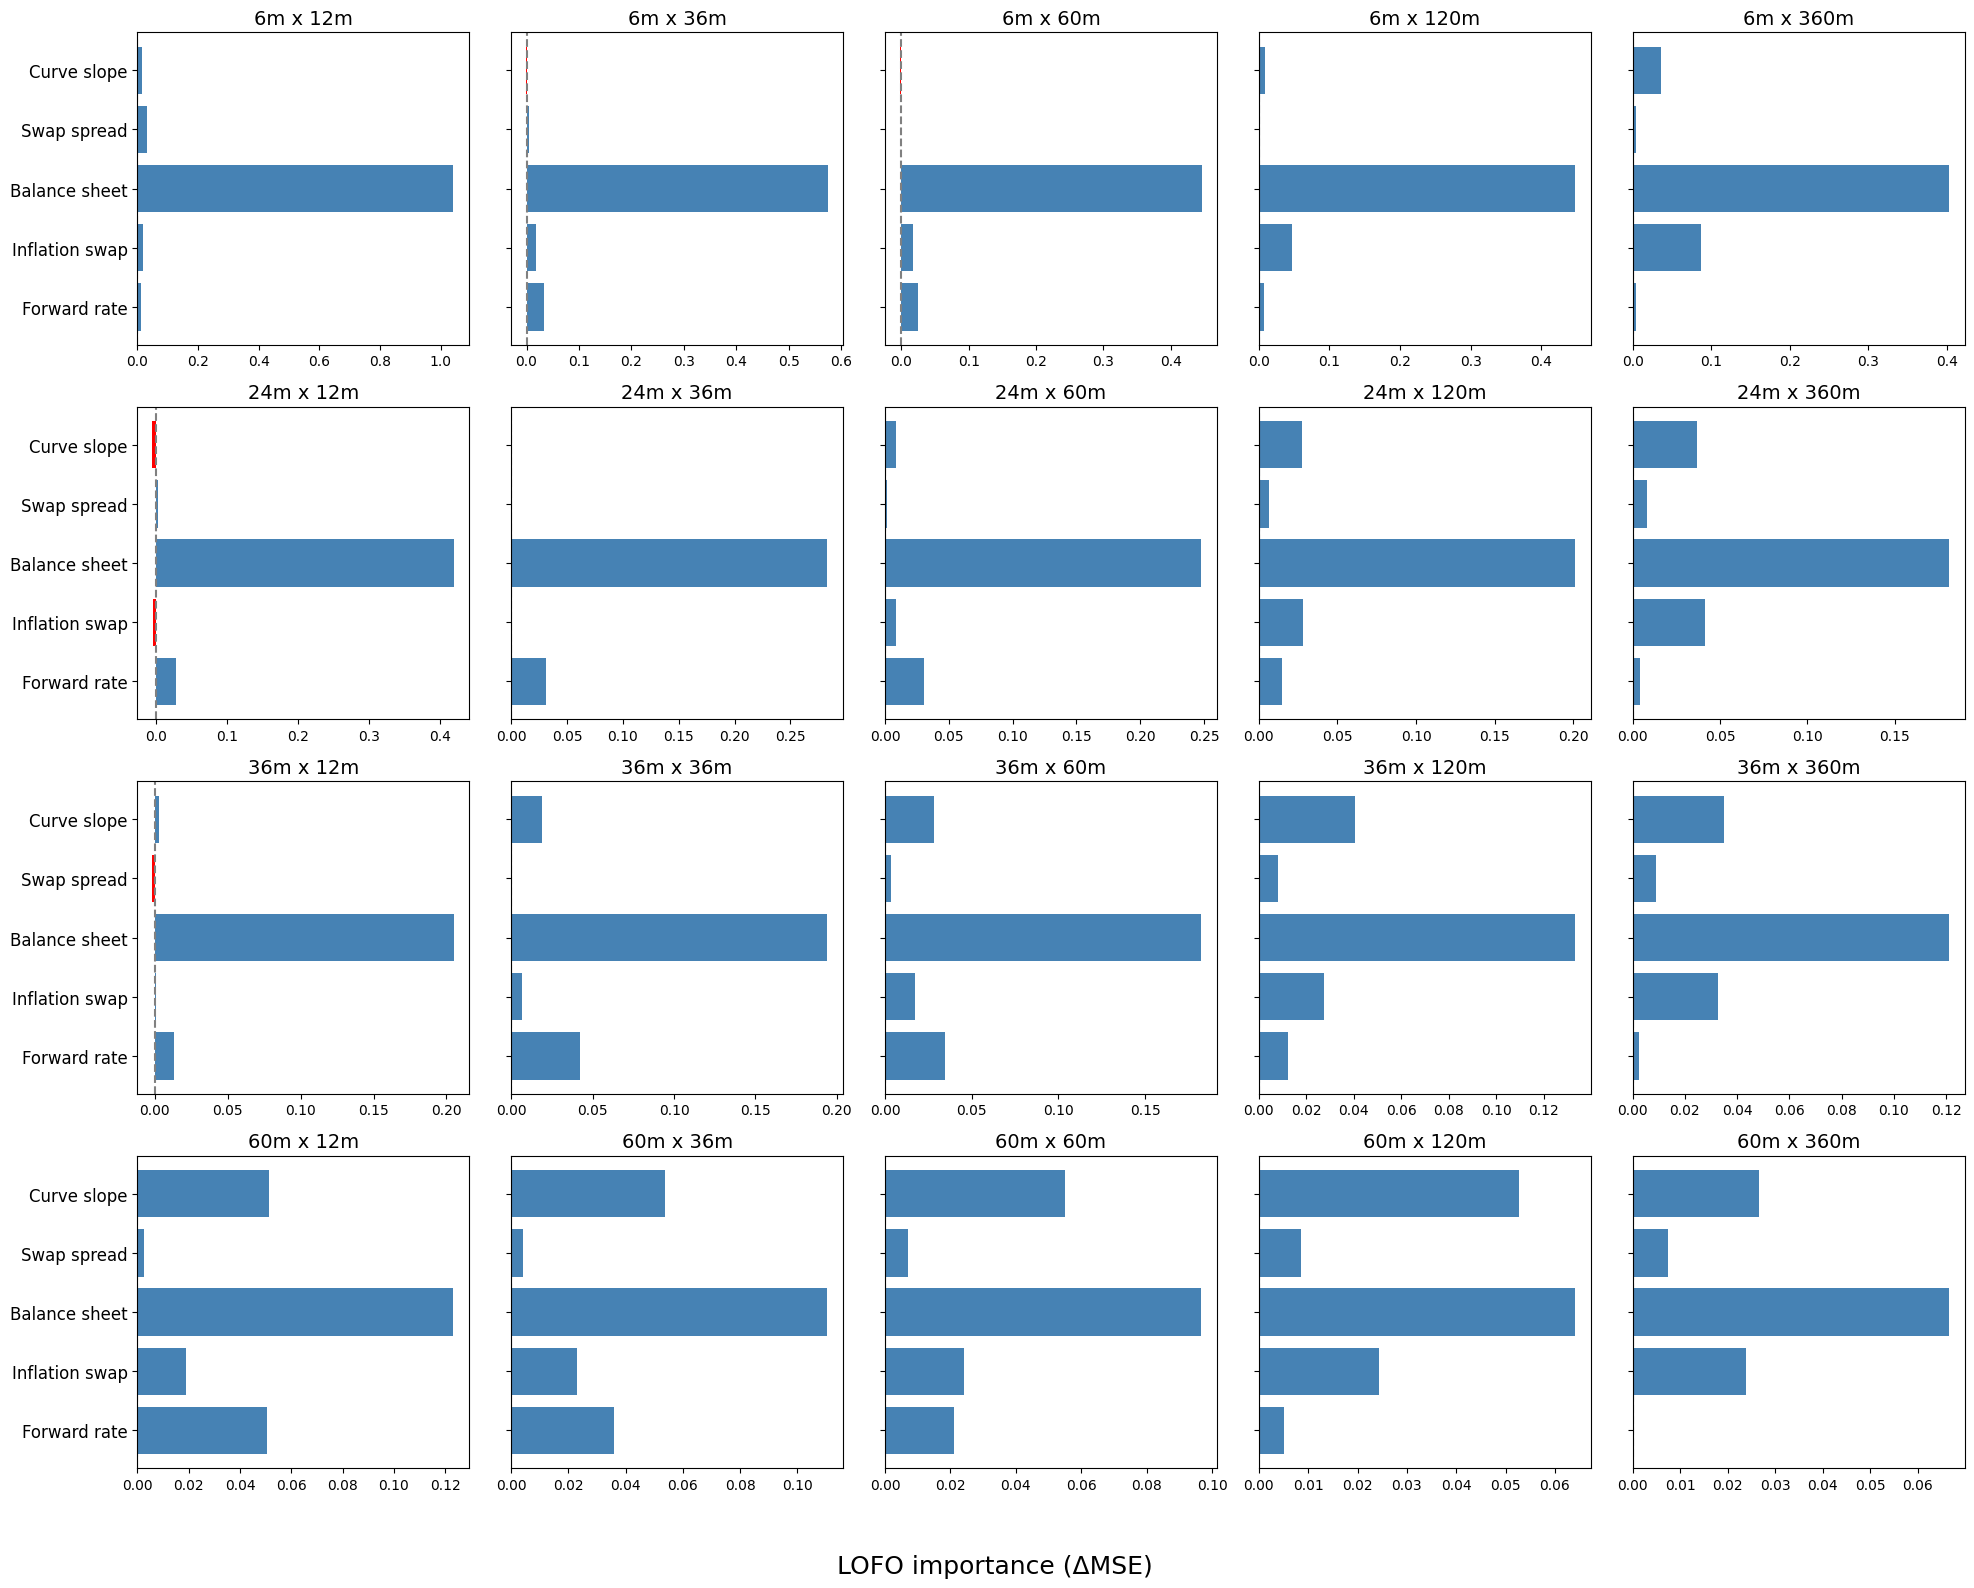

In [ ]:
# Pretty labels for plotting
label_map = {
    'value_rate': 'Forward rate',
    '5y5y_inflation_swap': 'Inflation swap',
    'balance_sheet': 'Balance sheet',
    '10y_swap_spread': 'Swap spread',
    '3m3m_1y3m_curve_slope': 'Curve slope'
}

# Keep your imports and data prep as-is
macro_features = list(label_map.keys())

# Get all unique (start_months, tenor_months) pairs and filter:
combinations = (
    usd_regression_df[['start_months', 'tenor_months']]
    .drop_duplicates()
    .sort_values(['start_months', 'tenor_months'])
    .values.tolist()
)
combinations = [(start, tenor) for (start, tenor) in combinations if start not in [3, 12] and tenor not in [24, 84]]

# Layout: 4 rows × 5 columns
ncols = 5
nrows = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), sharey=True)
axes = axes.flatten()

for idx, (start, tenor) in enumerate(combinations[:nrows*ncols]):
    df_sub = usd_regression_df.query(
        "start_months == @start and tenor_months == @tenor"
    ).dropna(subset=macro_features + ['residuals'])
    if len(df_sub) < 50:
        axes[idx].set_visible(False)
        continue

    X = df_sub[macro_features]
    y = df_sub['residuals']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 1) Original model error
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    e_orig = mean_squared_error(y_test, y_pred)

    # 2) LOFO for each feature
    lofo_scores = []
    for feature in macro_features:
        X_train_lofo = X_train.drop(columns=[feature])
        X_test_lofo = X_test.drop(columns=[feature])
        model_lofo = LinearRegression().fit(X_train_lofo, y_train)
        y_pred_lofo = model_lofo.predict(X_test_lofo)
        e_lofo = mean_squared_error(y_test, y_pred_lofo)
        lofo_scores.append(e_lofo - e_orig)

    # Colors: red if negative, steelblue if positive
    colors = ['red' if v < 0 else 'steelblue' for v in lofo_scores]

    # 3) Plot
    ax = axes[idx]
    y_pos = np.arange(len(macro_features))
    ax.barh(y_pos, lofo_scores, color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels([label_map[f] for f in macro_features], fontsize=14)  # use pretty labels
    ax.set_title(f'{start}m x {tenor}m', fontsize=14)
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_ylabel('')

# Hide any unused axes
for j in range(len(combinations[:nrows*ncols]), len(axes)):
    axes[j].set_visible(False)

# Shared x-label for the whole figure
fig.supxlabel('LOFO importance (ΔMSE)', fontsize=18)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()
